In [48]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import dezero
from dezero import cuda
import dezero.functions as F
import dezero.layers as L
from dezero import DataLoader
from dezero.models import Sequential
from dezero.optimizers import Adam
use_gpu = cuda.gpu_enable
print(use_gpu)


True


In [122]:
dict_data = np.load('8bit_characters_50x50.npz')
# extract the first array
data = dict_data['arr_0']
data_with_label = []
for i in range(len(data)):
    reshaped = np.transpose(data[i], (2, 0, 1))
    data_with_label.append((reshaped, i))
dataloader = DataLoader(data_with_label, batch_size=32, shuffle=True)

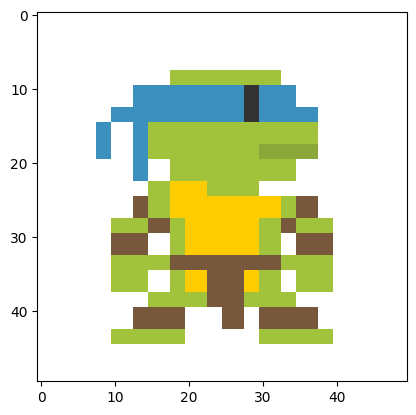

(50, 50, 3)


In [123]:
def plot_single_image(img):
    plt.imshow(img)
    plt.show()

plot_single_image(data[0])
print(data[0].shape)

In [124]:
def plot_images(imgs, grid_size = 5):
    """
    imgs: vector containing all the numpy images
    grid_size: 2x2 or 5x5 grid containing images
    """
     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")

    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        if i >= len(imgs):
            break
        plt.imshow(imgs[i])
    plt.show()
    plt.close()

In [125]:
def init_weight(dis, gen,):
    # Input dummy data to initialize weights
    batch_size = 1
    z = np.random.rand(batch_size, 100, 1, 1)
    fake_images = gen(z)
    dis(fake_images)

    for l in dis.layers + gen.layers:
        classname = l.__class__.__name__
        if classname.lower() in ('conv2d', 'linear', 'deconv2d'):
            l.W.data = 0.02 * np.random.randn(*l.W.data.shape)

In [126]:

gen = Sequential(
    L.Deconv2d(in_channels=100, out_channels=512, kernel_size=5, stride=2, pad=0, nobias=True),
    L.BatchNorm(),
    F.relu,
    
    L.Deconv2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, pad=0, nobias=True),
    L.BatchNorm(),
    F.relu,

    L.Deconv2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.relu,

    L.Deconv2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, pad=1, nobias=True),
    F.tanh,
)

In [127]:
# gen.plot('test.png')

In [128]:
dis = Sequential(
    L.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, pad=1, nobias=True),
    F.leaky_relu,

    L.Conv2d(in_channels=32, out_channels=32*2, kernel_size=3, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=32*2, out_channels=32*4, kernel_size=5, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=32*4, out_channels=32*8, kernel_size=2, stride=2, pad=0, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=32*8, out_channels=1, kernel_size=3, stride=1, pad=0, nobias=True),
    F.sigmoid,
)

In [129]:
# test
gen.to_cpu()
dis.to_cpu()
test = np.random.randn(32,3,50,50)
print(test.shape)
print(dis(test).shape)

(32, 3, 50, 50)
(32, 1, 1, 1)


In [130]:
opt_g = Adam(alpha=0.0002, beta1=0.5).setup(gen)
opt_d = Adam(alpha=0.0002, beta1=0.5).setup(dis)


In [131]:
batch_size = 32

init_weight(dis, gen)

In [132]:
if use_gpu:
    gen.to_gpu()
    dis.to_gpu()
    dataloader.to_gpu()
    xp = cuda.cupy
else:
    xp = np

label_real = xp.ones(batch_size).astype(int)
label_fake = xp.zeros(batch_size).astype(int)
test_z = xp.random.randn(32,100, 1, 1)
print(gen(test_z).shape)

(32, 3, 50, 50)


In [133]:
def generate_image():
    with dezero.test_mode():
        fake_images = gen(test_z)

    img = cuda.as_numpy(fake_images.data)
    img = (img + 1)/2
    img = np.transpose(img, (0, 2, 3, 1))
    fig = plt.figure(figsize = (8, 8))
    columns = rows = 5
    plt.title("Training Images")
    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        if i >= len(img):
            break
        plt.imshow(img[i])
    plt.show()
    plt.close()
    #plt.savefig('gan_{}.png'.format(idx))

epoch: 0.45, loss_d: 1.0650, loss_g: 2.2488


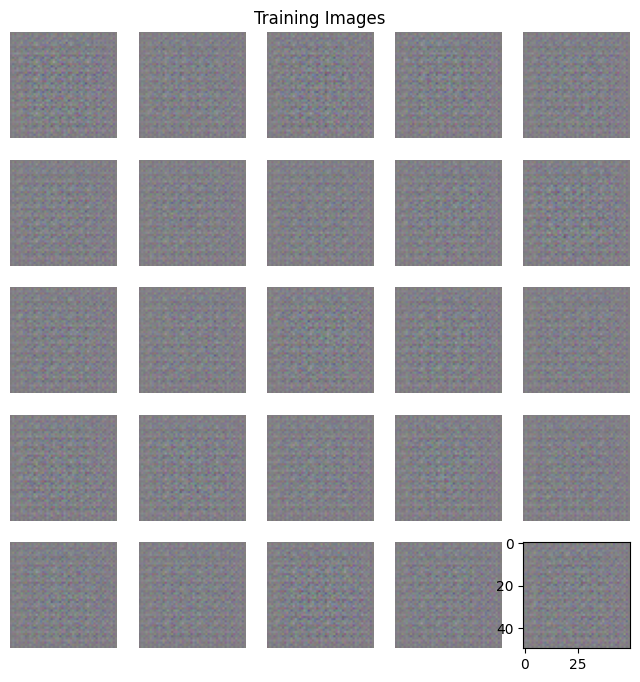

epoch: 1.45, loss_d: 0.4666, loss_g: 3.9159


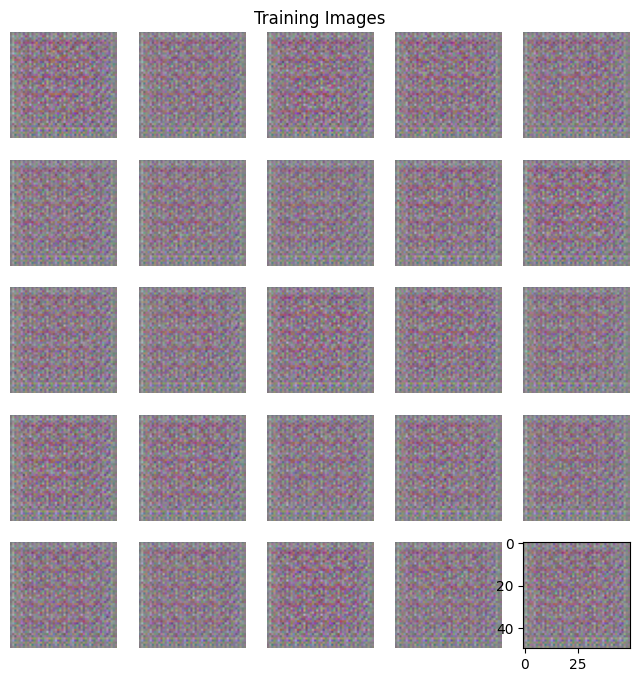

epoch: 3.45, loss_d: 0.3260, loss_g: 3.8971


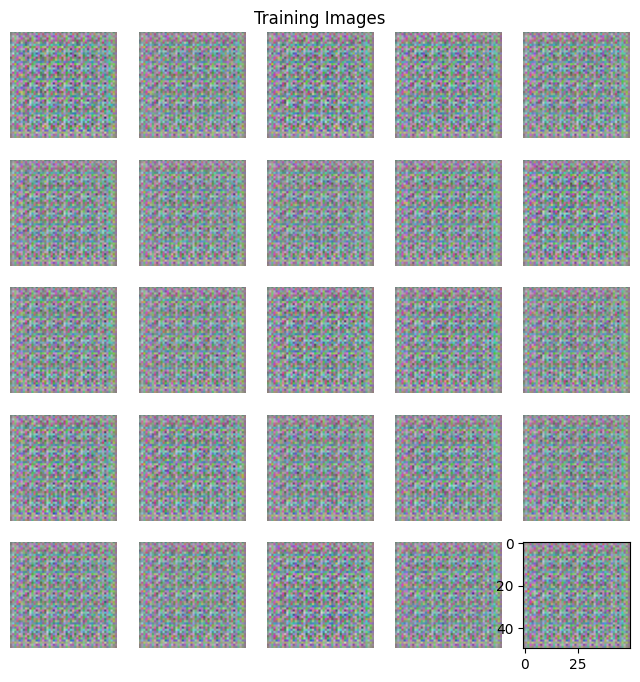

epoch: 4.45, loss_d: 0.2975, loss_g: 4.0688


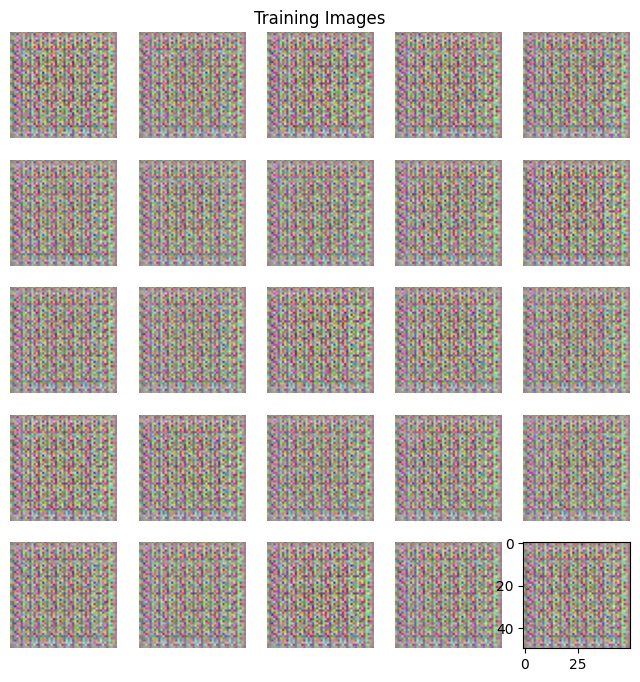

In [134]:
max_epoch = 5

for epoch in range(max_epoch):
    avg_loss_d = 0
    avg_loss_g = 0
    cnt = 0

    for x, t in dataloader:
        # print(x.shape, t.shape)
        cnt += 1
        if len(t) != batch_size:
            continue

        # Update discriminator
        z = xp.random.randn(batch_size, 100, 1, 1).astype(np.float32)
        fake_images = gen(z)
        y_real = dis(x)
        y_fake = dis(fake_images)

        loss_d = F.binary_cross_entropy(y_real, label_real) +\
              F.binary_cross_entropy(y_fake, label_fake)
        gen.cleargrads()
        dis.cleargrads()
        loss_d.backward()
        opt_d.update()

        # Update generator
        y_fake = dis(fake_images)
        loss_g = F.binary_cross_entropy(y_fake, label_real)
        gen.cleargrads()
        dis.cleargrads()
        loss_g.backward()
        opt_g.update()

        # Print loss & generate image
        avg_loss_d += loss_d.data
        avg_loss_g += loss_g.data
        interval = 100 if use_gpu else 5
        if cnt % 10 == 0:
            epoch_dt = epoch + cnt / dataloader.max_iter
            print('epoch: {:.2f}, loss_d: {:.4f}, loss_g: {:.4f}'.format(
                epoch_dt, loss_d.data, loss_g.data))
            generate_image()